# **Thư viện**

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.dates as mdates
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


# **Dữ liệu**

In [34]:

df = pd.read_csv("../data/processed/EUR_VND_Exchange_Rate.csv", parse_dates=["Date"])
df["Date"] = pd.to_datetime(df["Date"])

df = df.set_index('Date')
df = df.select_dtypes(include=[np.number]).astype(np.float32)

lags = 30
for i in range(1, lags + 1):
    df[f'lag_{i}'] = df['Sell'].shift(i)
df.dropna(inplace=True)

timestamps = df.index.values  # Cập nhật ở đây, sau khi dropna

X = df.drop(columns=['Sell']).values
y = df['Sell'].values

df.tail()

,Sell,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30
Date,,,,,,,,,,,,,,,,,,,,,
2025-04-07,29106.519531,29106.519531,29106.519531,29106.519531,29245.750000,28437.330078,28516.390625,28459.009766,28362.949219,28362.949219,...,28560.130859,28438.750000,28438.750000,28438.750000,28507.570312,28509.990234,28534.269531,28427.619141,28468.929688,28468.929688
2025-04-08,29215.210938,29106.519531,29106.519531,29106.519531,29106.519531,29245.750000,28437.330078,28516.390625,28459.009766,28362.949219,...,28730.009766,28560.130859,28438.750000,28438.750000,28438.750000,28507.570312,28509.990234,28534.269531,28427.619141,28468.929688
2025-04-09,29443.519531,29215.210938,29106.519531,29106.519531,29106.519531,29106.519531,29245.750000,28437.330078,28516.390625,28459.009766,...,28707.859375,28730.009766,28560.130859,28438.750000,28438.750000,28438.750000,28507.570312,28509.990234,28534.269531,28427.619141
2025-04-10,29178.759766,29443.519531,29215.210938,29106.519531,29106.519531,29106.519531,29106.519531,29245.750000,28437.330078,28516.390625,...,28663.919922,28707.859375,28730.009766,28560.130859,28438.750000,28438.750000,28438.750000,28507.570312,28509.990234,28534.269531
2025-04-11,29775.689453,29178.759766,29443.519531,29215.210938,29106.519531,29106.519531,29106.519531,29106.519531,29245.750000,28437.330078,...,28481.259766,28663.919922,28707.859375,28730.009766,28560.130859,28438.750000,28438.750000,28438.750000,28507.570312,28509.990234


# **Train/Test**

In [35]:
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]
train_timestamps, test_timestamps = timestamps[:train_size], timestamps[train_size:]

# **Mô hình Random Forest**

In [14]:
def train_rf(X_train, y_train, model_path):
    """
    Huấn luyện Random Forest và lưu mô hình với tham số tối ưu
    """
    param_grid = {
        'n_estimators': [100, 200, 300, 400, 500],
        'max_depth': [5, 10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    model = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_

    joblib.dump(best_model, model_path)

    return best_model

def build_rf_model(best_hp):
    """
    Xây dựng mô hình Random Forest từ tham số tối ưu
    """
    model = RandomForestRegressor(
        n_estimators=best_hp.n_estimators,
        max_depth=best_hp.max_depth,
        min_samples_split=best_hp.min_samples_split,
        min_samples_leaf=best_hp.min_samples_leaf,
        random_state=42
    )
    return model


In [15]:
model_path = r"D:\eur-vnd-exchange-rate\models\RandomForest\best_rf_prices.pkl"
best_model = train_rf(X_train, y_train, model_path)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2892: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [16]:
best_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 20,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

# **Đánh giá mô hình**

In [17]:
y_pred_test = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_test)
mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_test)
mape = mean_absolute_percentage_error(y_test, y_pred_test)
print(f"MAE: {mae:.4f}\nMSE: {mse:.4f}\nRMSE: {rmse:.4f}{r2:.4f}\nMAPE: {mape:.4f} ({mape * 100:.2f}%)")


MAE: 76.3123
MSE: 13724.2105
RMSE: 117.15040.9541
MAPE: 0.0027 (0.27%)


# **Dự đoán và thực tế**

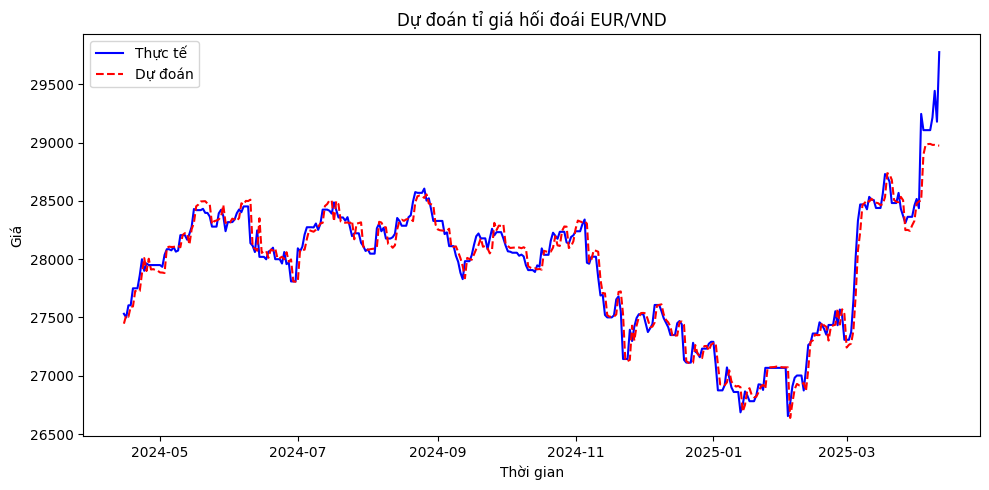

In [36]:
y_pred_test = best_model.predict(X_test)

# Tạo test_timestamps từ chỉ mục của dữ liệu kiểm tra (nếu không có thời gian sẵn)
#test_timestamps = pd.to_datetime(test_timestamps)  # Đảm bảo timestamps là datetime

# Vẽ biểu đồ chỉ với dữ liệu kiểm tra (dự đoán và thực tế)
plt.figure(figsize=(10, 5))
plt.plot(test_timestamps, y_test, label="Thực tế", color="blue")
plt.plot(test_timestamps, y_pred_test, label="Dự đoán", linestyle="dashed", color="red")

plt.xlabel("Thời gian")
plt.ylabel("Giá")
plt.title("Dự đoán tỉ giá hối đoái EUR/VND")

# Chỉ hiển thị các năm trên trục x
# plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Hiển thị theo năm
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Định dạng chỉ hiển thị năm
# plt.xticks(rotation=45)

plt.legend()
plt.tight_layout()
plt.show()

# **Dự đoán 30 ngày tiếp theo**


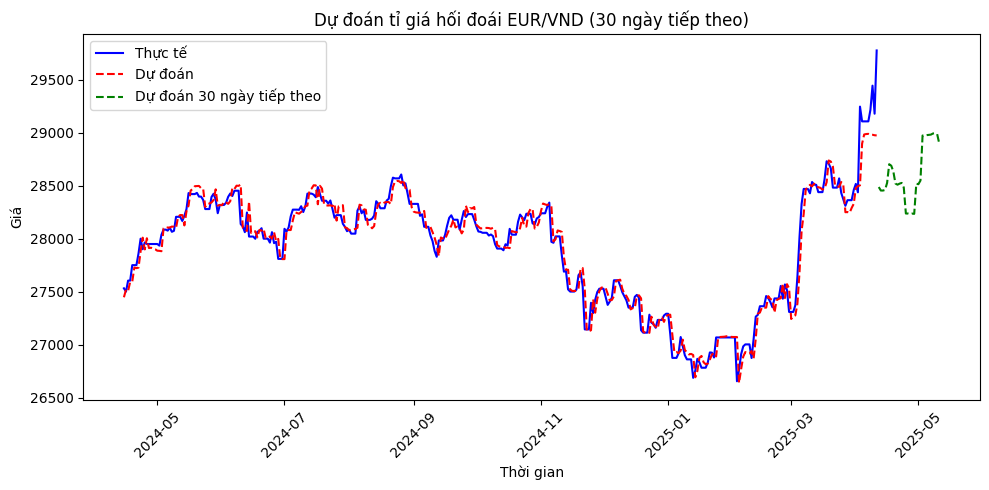

Dự đoán 30 ngày tiếp theo:
2025-04-12: 28486.7503
2025-04-13: 28453.9160
2025-04-14: 28453.6716
2025-04-15: 28459.3136
2025-04-16: 28526.0327
2025-04-17: 28702.2178
2025-04-18: 28687.9515
2025-04-19: 28632.2686
2025-04-20: 28519.9657
2025-04-21: 28509.1037
2025-04-22: 28519.1615
2025-04-23: 28525.5716
2025-04-24: 28481.9734
2025-04-25: 28236.9742
2025-04-26: 28236.7713
2025-04-27: 28230.8311
2025-04-28: 28236.3685
2025-04-29: 28233.6739
2025-04-30: 28517.9471
2025-05-01: 28513.5613
2025-05-02: 28548.2200
2025-05-03: 28972.9958
2025-05-04: 28972.3477
2025-05-05: 28976.6971
2025-05-06: 28979.1027
2025-05-07: 28981.5500
2025-05-08: 28992.1654
2025-05-09: 28993.7932
2025-05-10: 28986.6970
2025-05-11: 28898.5352


In [37]:
def predict_next_30_days(model, last_30_values, lags=30):
    # Tạo DataFrame với các giá trị cuối cùng (lag) để dự đoán các giá trị tiếp theo
    predictions = []
    current_input = last_30_values.copy()  # Copy giá trị cuối cùng vào input ban đầu
    
    for i in range(30):  # Dự đoán 30 ngày tiếp theo
        # Tạo các lag features từ dữ liệu hiện tại
        input_lags = np.array(current_input[-lags:]).reshape(1, -1)
        
        # Dự đoán giá trị tiếp theo
        next_value = model.predict(input_lags)[0]
        predictions.append(next_value)
        
        # Cập nhật input với giá trị dự đoán mới
        current_input = np.append(current_input, next_value)

    return predictions

# Lấy 30 giá trị cuối cùng trong dữ liệu huấn luyện
last_30_values = df['Sell'].values[-30:]

# Dự đoán 30 ngày tiếp theo
predictions_30_days = predict_next_30_days(best_model, last_30_values)

# Tạo mốc thời gian cho 30 ngày tiếp theo
last_date = df.index[-1]
future_dates = pd.date_range(last_date, periods=31, freq='D')[1:]  # Bắt đầu từ ngày tiếp theo

# Vẽ biểu đồ với dự đoán 30 ngày tiếp theo
plt.figure(figsize=(10, 5))
plt.plot(test_timestamps, y_test, label="Thực tế", color="blue")
plt.plot(test_timestamps, y_pred_test, label="Dự đoán", linestyle="dashed", color="red")
plt.plot(future_dates, predictions_30_days, label="Dự đoán 30 ngày tiếp theo", linestyle="dashed", color="green")

plt.xlabel("Thời gian")
plt.ylabel("Giá")
plt.title("Dự đoán tỉ giá hối đoái EUR/VND (30 ngày tiếp theo)")

# Định dạng trục x hiển thị theo ngày
plt.xticks(rotation=45)

plt.legend()
plt.tight_layout()
plt.show()

# In kết quả dự đoán 30 ngày tiếp theo
print("Dự đoán 30 ngày tiếp theo:")
for date, prediction in zip(future_dates, predictions_30_days):
    print(f"{date.strftime('%Y-%m-%d')}: {prediction:.4f}")
